In [353]:
import pyspark

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [4]:
#read data
location_df=spark.read.csv("DataSample.csv",inferSchema=True,header=True)

In [5]:
location_df.show(5)

+-------+--------------------+-------+--------+---------+--------+---------+
|    _ID|              TimeSt|Country|Province|     City|Latitude|Longitude|
+-------+--------------------+-------+--------+---------+--------+---------+
|4516516|2017-06-21 00:00:...|     CA|      ON| Waterloo|43.49347|-80.49123|
|4516547|2017-06-21 18:00:...|     CA|      ON|   London| 42.9399| -81.2709|
|4516550|2017-06-21 15:00:...|     CA|      ON|   Guelph| 43.5776| -80.2201|
|4516600|2017-06-21 15:00:...|     CA|      ON|Stratford| 43.3716| -80.9773|
|4516613|2017-06-21 15:00:...|     CA|      ON|Stratford| 43.3716| -80.9773|
+-------+--------------------+-------+--------+---------+--------+---------+
only showing top 5 rows



In [6]:
poi_df=spark.read.csv("POIList.csv",inferSchema=True,header=True)

# Data Cleaning up

In [7]:
clean_poi=poi_df.dropDuplicates([' Latitude', 'Longitude'])
clean_poi.show()

+-----+---------+-----------+
|POIID| Latitude|  Longitude|
+-----+---------+-----------+
| POI1|53.546167|-113.485734|
| POI4| 45.22483| -63.232729|
| POI3|45.521629| -73.566024|
+-----+---------+-----------+



In [8]:
#clean location data and count rows removed
clean_location=location_df.dropDuplicates([' TimeSt','Latitude', 'Longitude'])
print(location_df.count()-clean_location.count())

2026


# Data Label

In [9]:
from geopy.distance import geodesic

In [10]:
import numpy as np

In [11]:
clean_poi.select([' Latitude', 'Longitude']).show()
Lat = []
Lng = []
Lat = [float(row[' Latitude']) for row in clean_poi.collect()]
Lng = [float(row['Longitude']) for row in clean_poi.collect()]
poi_1 = (Lat[0],Lng[0])
poi_4 = (Lat[1],Lng[1])
poi_3 = (Lat[2],Lng[2])
geodesic(poi_1, poi_3).miles

+---------+-----------+
| Latitude|  Longitude|
+---------+-----------+
|53.546167|-113.485734|
| 45.22483| -63.232729|
|45.521629| -73.566024|
+---------+-----------+



1851.5920499579452

In [12]:
Lat_location=[]
Lng_location=[]
Lat_location = [float(row['Latitude']) for row in clean_location.collect()]
Lng_location = [float(row['Longitude']) for row in clean_location.collect()]

In [13]:
# loop to calculate the distance and append the closest poi to poi list
poi=[]
dist_to_poi=[]
for i in range(len(Lat_location)):
    target=(Lat_location[i],Lng_location[i])
    dist_1=geodesic(poi_1, target).miles
    dist_3=geodesic(poi_3, target).miles
    dist_4=geodesic(poi_4, target).miles
    dist_to_poi.append(min(dist_1,dist_3,dist_4))
    if dist_to_poi[i] == dist_1:
        poi.append("1")
    elif dist_to_poi[i]== dist_3:
        poi.append("2")
    else:
        poi.append("3")
print(len(dist_to_poi))
print(len(poi))

19999
19999


In [14]:
poi=list(map(int,poi))
dist_to_poi=list(map(float,dist_to_poi))

In [16]:
from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import stddev

In [17]:
#create poi dataframe
rdd1=sc.parallelize(poi)
row_rdd1=rdd1.map(lambda x :Row(x))
df1=spark.createDataFrame(row_rdd1,["poi"])
df1_withid=df1.withColumn('id',monotonically_increasing_id())
df1_withid.show(10)

+---+---+
|poi| id|
+---+---+
|  2|  0|
|  2|  1|
|  2|  2|
|  2|  3|
|  1|  4|
|  1|  5|
|  2|  6|
|  2|  7|
|  2|  8|
|  2|  9|
+---+---+
only showing top 10 rows



In [18]:
#create dist_to_poi dataframe
rdd2=sc.parallelize(dist_to_poi)
row_rdd2=rdd2.map(lambda x :Row(x))
df2=spark.createDataFrame(row_rdd2,["dist_to_poi"])
df2_withid=df2.withColumn('id',monotonically_increasing_id())
df2_withid.show(10)

+------------------+---+
|       dist_to_poi| id|
+------------------+---+
| 328.8084908532704|  0|
|12.042170525902616|  1|
| 418.1879318935508|  2|
|110.68378900853419|  3|
| 7.347131815420794|  4|
|3.3620209048408687|  5|
| 331.0344190863416|  6|
|258.65924358063734|  7|
| 372.0306519606404|  8|
| 314.4848622799323|  9|
+------------------+---+
only showing top 10 rows



In [19]:
# inner join two dataframes 
new_df=df1_withid.join(df2_withid, df1_withid.id==df2_withid.id,'inner').drop(df2_withid.id).orderBy("id")

In [20]:
new_df.show(10)

+---+---+------------------+
|poi| id|       dist_to_poi|
+---+---+------------------+
|  2|  0| 328.8084908532704|
|  2|  1|12.042170525902616|
|  2|  2| 418.1879318935508|
|  2|  3|110.68378900853419|
|  1|  4| 7.347131815420794|
|  1|  5|3.3620209048408687|
|  2|  6| 331.0344190863416|
|  2|  7|258.65924358063734|
|  2|  8| 372.0306519606404|
|  2|  9| 314.4848622799323|
+---+---+------------------+
only showing top 10 rows



In [60]:
data=new_df.groupBy("poi").count()

In [53]:
data.printSchema()

root
 |-- poi: long (nullable = true)
 |-- count: long (nullable = false)



# data analysis

In [22]:
#avg distance
new_df.groupBy("poi").agg({"dist_to_poi": "avg"}).show()

+---+------------------+
|poi|  avg(dist_to_poi)|
+---+------------------+
|  1|187.84777266807257|
|  3|309.66612246256705|
|  2|281.26952193172895|
+---+------------------+



In [23]:
#distance standard deviation
new_df.groupBy("poi").agg(stddev("dist_to_poi")).alias("stdev").show()

+---+------------------------+
|poi|stddev_samp(dist_to_poi)|
+---+------------------------+
|  1|      256.62069607728324|
|  3|       917.3259357340281|
|  2|       139.2636515071673|
+---+------------------------+



In [24]:
group_data=new_df.groupBy("poi")
radius_data=group_data.agg({"dist_to_poi":"max"})

In [27]:
#max distance from poi = circle radius
radius_data.show()

+---+------------------+
|poi|  max(dist_to_poi)|
+---+------------------+
|  1|7171.7603385915745|
|  3|5819.3498050450535|
|  2| 932.3384198840129|
+---+------------------+



In [42]:
ra = radius_data.withColumnRenamed('max(dist_to_poi)', 'radius')

In [44]:
#rename
ra.show()

+---+------------------+
|poi|            radius|
+---+------------------+
|  1|7171.7603385915745|
|  3|5819.3498050450535|
|  2| 932.3384198840129|
+---+------------------+



In [46]:
area_df=ra.withColumn("area",ra.radius**2*np.pi).select("radius",'poi',"area")

In [47]:
#circle area
area_df.show()

+------------------+---+--------------------+
|            radius|poi|                area|
+------------------+---+--------------------+
|7171.7603385915745|  1|1.6158513633000168E8|
|5819.3498050450535|  3|1.0638950790841758E8|
| 932.3384198840129|  2|   2730844.899645731|
+------------------+---+--------------------+



In [86]:
df_1=area_df.join(data, area_df.poi==data.poi,'inner')

In [87]:
df_1.printSchema()

root
 |-- radius: double (nullable = true)
 |-- poi: long (nullable = true)
 |-- area: double (nullable = true)
 |-- poi: long (nullable = true)
 |-- count: long (nullable = false)



In [94]:
count = [float(row['count']) for row in df_1.collect()]
area = [float(row['area']) for row in df_1.collect()]

In [120]:
#density
density=[]
count_a=np.asarray(count)
area_a=np.asarray(area)
for i in range(0, 3):
    dens=(count_a[i]/area_a[i])
    density.append(dens)
density

[6.01911798380812e-05, 4.483524826626814e-06, 0.0035871682061734164]

# 4a. Model

In [155]:
#dependencies

#normalize models
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

#visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
poi_and_dist=new_df.drop("id")

In [129]:
# filter data to pois 
poi_1=poi_and_dist.filter('poi=1')

In [141]:
poi_2=poi_and_dist.filter('poi=2')

DataFrame[poi: bigint, dist_to_poi: double]

In [142]:
poi_3=poi_and_dist.filter('poi=3')

In [131]:
dist_1 = [float(row['dist_to_poi']) for row in poi_1.collect()]

In [143]:
dist_2=[float(row['dist_to_poi']) for row in poi_2.collect()]
dist_3=[float(row['dist_to_poi']) for row in poi_3.collect()]

In [161]:
# data preparing to be normalized
data_a=np.asarray(dist_1)
data_1=data_a.reshape(-1,1)

data_b=np.asarray(dist_2)
data_2=data_b.reshape(-1,1)

data_c=np.asarray(dist_3)
data_3=data_c.reshape(-1,1)

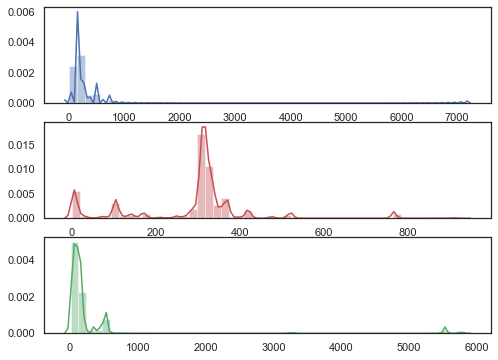

In [204]:
#make a density plot to view data
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(3, 1)
sns.set(rc={'figure.figsize':(8,6)})
ax1=sns.distplot(data_1, color="b",ax=axes[0])
ax2=sns.distplot(data_2, color="r",ax=axes[1])
ax3=sns.distplot(data_3, color="g",ax=axes[2])
# according to the graph poi_1 and poi_3 has extreme outliers 
# this may affect the choice of preprocess model

In [322]:
# these three models were fit to the data and compare the performance with each other
# according to the graph above 
# all poi data are distributed with extreme outliers
# requirement :" to be more sensitive around the average and provide as much visual differentiability as possible".
# i take it as in make more bars and lower bar heigh around the average by modelling
rs = RobustScaler()
qt = QuantileTransformer(n_quantiles=10, random_state=0)
pt = PowerTransformer()

In [348]:
def normalize_data(data):
    # fit poi_1 data using three models
    pt_fitted=pt.fit_transform(data)
    rs_fitted=rs.fit_transform(data)
    qt_fitted=qt.fit_transform(data)
    return pt_fitted,rs_fitted,qt_fitted

def plot_data(pt,rs,qt):
    # view fitted data on graph
    # Compare the effect of different scalers on data with outliers
    sns.set(style="white", palette="muted", color_codes=True)
    f, axes = plt.subplots(3, 1)
    sns.set(rc={'figure.figsize':(8,6)})
    ax1=sns.distplot(pt, color="b",ax=axes[0])
    ax2=sns.distplot(rs, color="r",ax=axes[1])
    ax3=sns.distplot(qt, color="g",ax=axes[2])


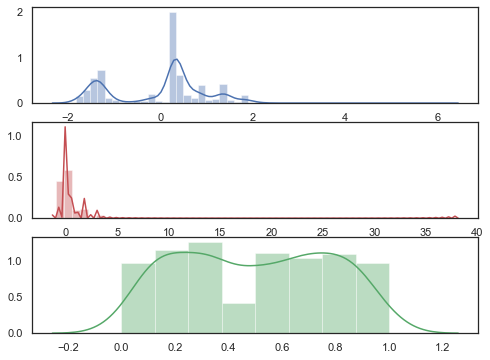

In [349]:
pt_fitted,rs_fitted,qt_fitted_1 = normalize_data(data_1)
plot_data(pt_fitted,rs_fitted,qt_fitted)

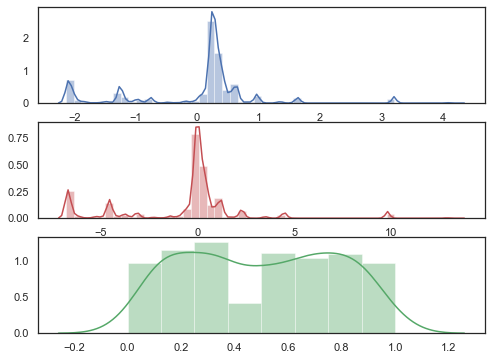

In [350]:
pt_fitted,rs_fitted,qt_fitted_2 = normalize_data(data_2)
plot_data(pt_fitted,rs_fitted,qt_fitted)

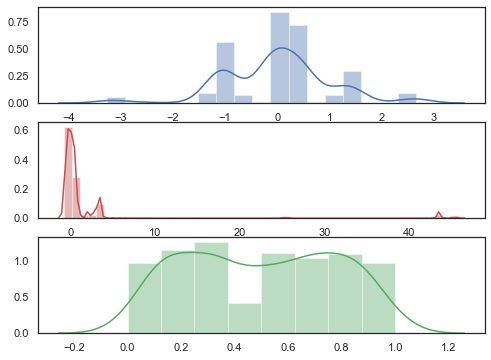

In [351]:
pt_fitted,rs_fitted,qt_fitted_3 = normalize_data(data_3)
plot_data(pt_fitted,rs_fitted,qt_fitted)

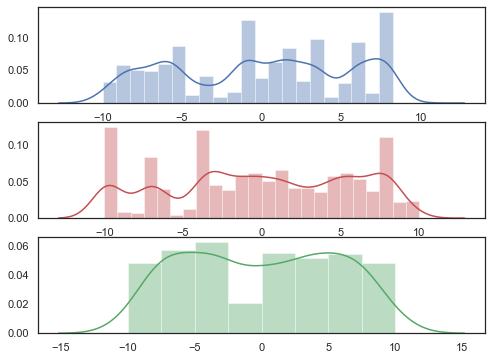

In [352]:
# selecting the best model which are all qt for pois
# reason to select the QuantileTransformer: 
# it considers the outlier and make bars relative flat
# I take that as "sensitive around the average and provide as much visual differentiability as possible"

# And mapping the data from -10 to 10
a=-10
b=10
qt_map_1=(b-a)*(qt_fitted_1-min(qt_fitted_1))/(max(qt_fitted_1)-min(qt_fitted_1))+a
qt_map_2=(b-a)*(qt_fitted_2-min(qt_fitted_2))/(max(qt_fitted_2)-min(qt_fitted_2))+a
qt_map_3=(b-a)*(qt_fitted_3-min(qt_fitted_3))/(max(qt_fitted_3)-min(qt_fitted_3))+a

plot_data(qt_map_1,qt_map_2,qt_map_3)

# 4b Pipeline Dependency(DAG)

In [213]:
#import networkx for DAG
import networkx as nx

In [214]:
G = nx.DiGraph()

In [234]:
# read relations.txt and append it
f = open("relations.txt", "r")
dependency=[]
for x in f:
  edge=(int(x.split("->")[0]),int(x.split("->")[1].rstrip('\n')))
  dependency.append(edge)

In [275]:
node=[]
f = open("task_ids.txt", "r")
for word in f.read().split(","):
    node.append(int(word))

In [277]:
G.add_nodes_from(node)
G.add_edges_from(dependency)

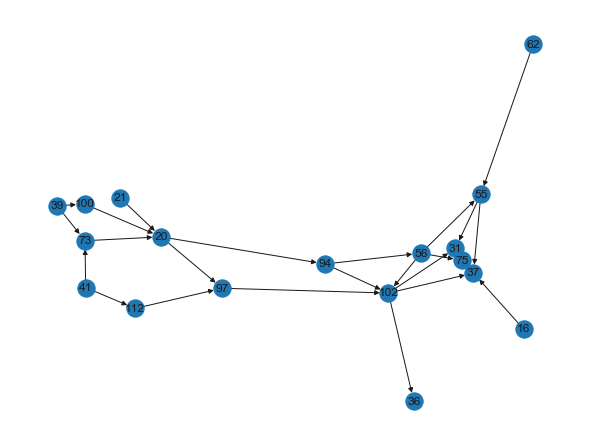

In [282]:
# draw graph
nx.draw_spectral(G,with_labels=True)

In [284]:
# the shortest path
nx.shortest_path(G, source=73, target=36, weight=None, method='dijkstra')

[73, 20, 97, 102, 36]